# PINO: Physics-Informed Neural Operator

## Solve
$$ \frac{d^2u(x)}{dx^2} = f(x) $$
$f(x)$: Given function  
$u(0)=u_0$, $u(1)=u_1$: Given boundary condition

### PINOの戦略
- PINNの場合は、与えられた$f(x)$, $u_0$, $u_1$などの条件に従うように、その都度関数 $u(x)$ を表すニューラルネットワークのハイパーパラメータ $\theta$ を学習（方程式を満たすように調整）していた。→ 条件が変わると学習し直し。
- 通常のニューラルネットワークは、入力として与えられた数値の組（例えば $f(x) = \sin(x)$, $u_0=0$, $u_1=1$）に対しする出力の数値の組 $u(x)=...$ を与える、いわゆる関数：数 → 数を学習するのに対し、作用素学習の考え方では、具体的な数値ではなく、入力関数 $f$ と出力関数 $u$ の間に関数同士の変換関係、いわゆる作用素：関数 → 関数の関係があるとして、その作用素を表現するようなネットワークをニューラルオペレータという構造で表す（表そうと頑張っている）
- PINOは作用素学習を用いたPINNの拡張として提案されている。
- このノートブックでは、(i) PINNの中で用いていたニューラルネットワークをDeepONetと呼ばれるニューラルオペレータ構造で代替し、 (ii) 特定のfの値に依らない作用素構造を抽出したいので、PINOでは、複数の問題条件設定[$f_0(x)$, $f_1(x)$, $f_2(x)$, ...]を同時に満たすようにDeepONetのハイパーパラメータを学習する、という2つの修正でPINOを実装している。（※PINOの原著論文ではさらに個別問題推定の際のファインチューニングも議論されているがここでは割愛。）
- こうして学習した作用素：$f \rightarrow u$によって、未知の問題条件 $f_\mathrm{unknown}$ に対しても、解 $u(x)$ を精度よく推定できると期待される。

In [1]:
$# --- ライブラリ ---
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from flax import linen as nn
from flax.training.train_state import TrainState
import optax
from jax import grad, vmap
from scipy.stats.qmc import Sobol
from scipy.integrate import solve_bvp
import functools
import numpy as np

# --- DeepONet モデル定義 ---
class DeepONet(nn.Module):
    branch_layers: list
    trunk_layers: list

    @nn.compact
    def __call__(self, param_input, eval_input):
        # --- Branch Net (単一ネットワーク Ver) ---
        # x = param_input
        # for w in self.branch_layers[:-1]:
        #     x = nn.tanh(nn.Dense(w)(x))
        # branch_out = nn.Dense(self.branch_layers[-1])(x)

        # --- Barnch Net (f と bc を個別のネットワークで処理 Ver) ---
        # param_input は入力関数fのサンプル値（例:100点）とDirichlet境界条件（2点）を連結したもの
        f_input = param_input[..., :-2]  # 関数 f(x) の部分のみ抽出
        bc_input = param_input[..., -2:]  # 境界条件 u(0), u(1) の部分のみ抽出

        # fに対してMLPを適用（通常のブランチネット）
        x_f = f_input
        for w in self.branch_layers[:-1]:
            x_f = nn.tanh(nn.Dense(w)(x_f))
        f_feat = nn.Dense(self.branch_layers[-1]-2)(x_f)  # 出力特徴量の次元数を減らしておく

        # 境界条件はそのまま使う（または軽くMLP処理しても良い）
        bc_feat = bc_input  # ここでは直接渡す簡略構成

        # fとbcの特徴を連結し、最終的なブランチ出力とする
        branch_out = jnp.concatenate([f_feat, bc_feat], axis=-1)

        # --- Trunk Net ---
        # 評価点 x に対するトランクネット処理
        y = eval_input
        for w in self.trunk_layers[:-1]:
            y = nn.tanh(nn.Dense(w)(y))
        trunk_out = nn.Dense(self.trunk_layers[-1])(y)

        # ブランチとトランクの出力の内積により、u(x) を出力
        return jnp.sum(branch_out * trunk_out, axis=-1, keepdims=True)

# --- PINO構造定義（DeepONetを使ったPoisson方程式学習）---
class PINO_Poisson:
    def __init__(self, model: nn.Module, D_param: int, lr: float = 1e-3):
        self.model = model
        dummy_param = jnp.zeros((1, D_param))   # 入力のダミー（学習用のshape指定）
        dummy_eval = jnp.zeros((1, 1))          # 評価点のダミー
        rng = jax.random.PRNGKey(0)
        params = self.model.init(rng, dummy_param, dummy_eval)  # モデル初期化
        tx = optax.adam(lr)
        self.state = TrainState.create(apply_fn=self.model.apply, params=params, tx=tx)

    # PDE項 + データ項の損失関数
    @functools.partial(jax.jit, static_argnums=(0,))
    def loss_fn(self, params, f_batch, x_col_batch, f_col_batch, x_obs_batch, u_obs_batch):
        def single_loss(f_sample, x_col, f_col, x_obs, u_obs):
            # u(x) を予測する関数
            u_fn = lambda x: self.model.apply(params, f_sample, x[None, :])[0, 0]

            # 微分計算（自動微分）
            dudx = grad(u_fn)
            d2udx2 = grad(lambda x: dudx(x)[0])

            # Poissonの残差 d²u/dx² - f の2乗誤差
            residual = vmap(lambda x, fx: d2udx2(x) - fx)(x_col, f_col)
            loss_pde = jnp.mean(residual**2)

            # 境界条件でのデータ誤差
            u_pred = vmap(lambda x: u_fn(x))(x_obs)
            loss_data = jnp.mean((u_pred - u_obs)**2)

            return loss_pde + loss_data  # 合計損失
        losses = vmap(single_loss)(f_batch, x_col_batch, f_col_batch, x_obs_batch, u_obs_batch)
        return jnp.mean(losses)

    # 学習ステップ（パラメータ更新）
    @functools.partial(jax.jit, static_argnums=(0,))
    def train_step(self, state, f_batch, x_col_batch, f_col_batch, x_obs_batch, u_obs_batch):
        loss, grads = jax.value_and_grad(self.loss_fn)(state.params, f_batch, x_col_batch, f_col_batch, x_obs_batch, u_obs_batch)
        return state.apply_gradients(grads=grads), loss

    def train(self, f_batch, x_col_batch, f_col_batch, x_obs_batch, u_obs_batch, n_epochs=1500):
        for epoch in range(n_epochs + 1):
            self.state, loss = self.train_step(self.state, f_batch, x_col_batch, f_col_batch, x_obs_batch, u_obs_batch)
            if epoch % (n_epochs//10) == 0:
                print(f"[Epoch {epoch}] Loss = {loss:.2e}")

    # u(x) だけを返す推論関数
    def predict(self, f_samples_batch, x_eval):
        def single_apply(f_sample):
            return vmap(lambda x: self.model.apply(self.state.params, f_sample, x[None, :])[0, 0])(x_eval)
        return vmap(single_apply)(f_samples_batch)

    # u(x), du/dx(x), d²u/dx²(x) をすべて返す推論関数
    def predict_with_derivatives(self, f_samples_batch, x_eval):
        def single_apply(f_sample):
            u_fn = lambda x: self.model.apply(self.state.params, f_sample, x[None, :])[0, 0]
            dudx_fn = grad(u_fn)
            d2udx2_fn = grad(lambda x: dudx_fn(x)[0])
            def eval_all(x):
                u_val = u_fn(x)
                du_val = dudx_fn(x)[0]
                d2u_val = d2udx2_fn(x)[0]
                return jnp.stack([u_val, du_val, d2u_val])
            return vmap(eval_all)(x_eval)
        return vmap(single_apply)(f_samples_batch)

# --- 関数生成：f(x) をFourier展開で定義するサンプル関数群を生成 ---
def generate_f_and_bc_list(n_sample, n_modes=10):
    key = jax.random.PRNGKey(42)
    key1, key2, key3 = jax.random.split(key, 3)
    k = jnp.arange(1, n_modes + 1).reshape(1, n_modes)
    A = (1 + 0.01 * jax.random.normal(key1, (n_sample, n_modes))) / k**2
    phi = jax.random.uniform(key2, (n_sample, n_modes), minval=0.0, maxval=2*jnp.pi)
    bc = jax.random.uniform(key3, (n_sample, 2), minval=-1.0, maxval=1.0)

    f_list, bc_list = [], []
    for i in range(n_sample):
        Ai, phii = A[i], phi[i]
        def f_i(x, Ai=Ai, phii=phii):
            x = x.reshape(-1, 1)
            return jnp.sum(Ai * jnp.sin(jnp.pi * k * x + phii), axis=1)
        f_list.append(f_i)
        bc_list.append(bc[i])
    return f_list, bc_list

# --- 学習セットアップ（複数の f, u0, u1 の問題セットを用意） ---
nbatch = 32
x_sample = jnp.linspace(0, 1, 100).reshape(-1, 1)
x_col = jnp.linspace(0, 1, 64).reshape(-1, 1)
x_obs = jnp.array([[0.0], [1.0]])
f_list, bc_list = generate_f_and_bc_list(nbatch)
f_unknown = f_list.pop()
bc_unknown = bc_list.pop()
nbatch = len(f_list) # = (original nbatch) - 1

f_batch = []
f_col_batch = []
u_obs_batch = []
for f, bc in zip(f_list, bc_list):
    f_sample = f(x_sample).reshape(-1)
    f_col = f(x_col).reshape(-1)
    u_obs = bc  # boundary values u(0), u(1)
    f_with_bc = jnp.concatenate([f_sample, u_obs])  # shape (102,)
    f_batch.append(f_with_bc)
    f_col_batch.append(f_col)
    u_obs_batch.append(u_obs)

f_batch = jnp.stack(f_batch)
f_col_batch = jnp.stack(f_col_batch)
x_col_batch = jnp.broadcast_to(x_col[None, :, :], (nbatch,) + x_col.shape)
x_obs_batch = jnp.broadcast_to(x_obs[None, :, :], (nbatch,) + x_obs.shape)
u_obs_batch = jnp.stack(u_obs_batch)

# --- モデル構造と学習 ---
branch_layers = [102, 64, 64, 64]
trunk_layers = [1, 64, 64, 64]
model = DeepONet(branch_layers, trunk_layers)
solver = PINO_Poisson(model, D_param=102)
solver.train(f_batch, x_col_batch, f_col_batch, x_obs_batch, u_obs_batch, n_epochs=5000)

# --- 比較用正解解（PINOの結果検証用として別数値手法で解を求めておく） ---
def solve_poisson_bvp(f_fn, bc, x_eval):
    x_np = np.linspace(0, 1, 1000)
    y_init = np.zeros((2, x_np.size))
    bc = np.array(bc)
    x_eval = np.array(x_eval)
    def numpy_compatible_f_fn(x):
        x = np.array(x).reshape(-1, 1)
        return np.array(f_fn(jnp.array(x)))  # 明示的にnpに変換

    def ode(x, y):
        x_reshaped = x.reshape(-1, 1)
        f_val = numpy_compatible_f_fn(x_reshaped).flatten()
        return np.vstack((y[1], f_val))

    def bc_fn(ya, yb):
        return np.array([ya[0] - bc[0], yb[0] - bc[1]])

    sol = solve_bvp(ode, bc_fn, x_np, y_init)
    if sol.status != 0:
        print("[Warning] BVP solver did not converge:", sol.message)
    return sol.sol(x_eval[:, 0])[0]

[Epoch 0] Loss = 4.66e+00
[Epoch 500] Loss = 1.56e-02
[Epoch 1000] Loss = 8.10e-03
[Epoch 1500] Loss = 3.49e-03
[Epoch 2000] Loss = 3.03e-03
[Epoch 2500] Loss = 3.23e-03
[Epoch 3000] Loss = 3.25e-03
[Epoch 3500] Loss = 2.75e-03
[Epoch 4000] Loss = 3.35e-03
[Epoch 4500] Loss = 2.52e-03
[Epoch 5000] Loss = 2.37e-03


推論 1 : 学習済み f(x), u0, u1


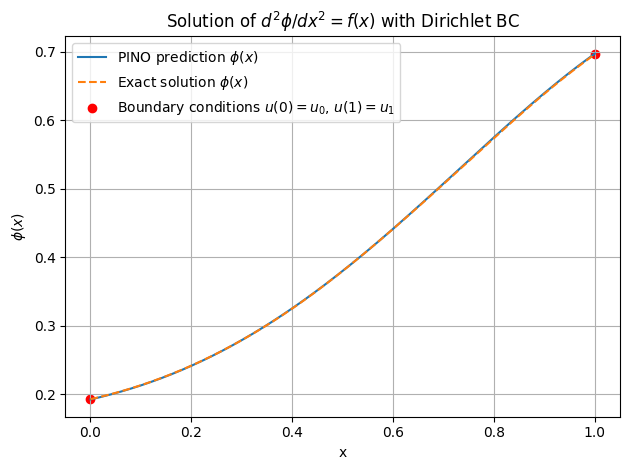

In [2]:
# --- 推論 1 : 学習済み f(x), u0, u1 ---
print("推論 1 : 学習済み f(x), u0, u1")
f_test = f_list[-1]
bc_test = bc_list[-1]

f_sample_test = f_test(x_sample).reshape(-1)
f_input_test = jnp.concatenate([f_sample_test, bc_test])[None, :]
x_plot = jnp.linspace(0, 1, 200).reshape(-1, 1)
u_pred = solver.predict(f_input_test, x_plot)[0]

# --- プロット ---
u_exact_test = solve_poisson_bvp(f_test, bc_test, x_plot)
plt.plot(x_plot[:, 0], u_pred, label="PINO prediction $\phi(x)$")
plt.plot(x_plot[:, 0], u_exact_test, '--', label="Exact solution $\phi(x)$")
plt.scatter(x_obs[:,0], bc_test, c="r", label="Boundary conditions $u(0)=u_0$, $u(1)=u_1$")
plt.xlabel("x")
plt.ylabel("$\phi(x)$")
plt.title("Solution of $d^2\phi/dx^2 = f(x)$ with Dirichlet BC")
plt.grid(); plt.legend(); plt.tight_layout(); plt.show()

# # --- ２階微分チェック ---
# u_pred, dudx_pred, d2udx2_pred = solver.predict_with_derivatives(f_input_test, x_plot)[0].T
# plt.plot(x_sample[:,0], f_sample_test, label="Given f(x)")
# plt.plot(x_plot[:,0], d2udx2_pred, '--', label="Pino prediction d^2u/dx^2")
# plt.xlabel("x")
# plt.title("Check $d^2\phi/dx^2 = f(x)$")
# plt.grid(); plt.legend(); plt.tight_layout(); plt.show()

推論 2 : 初見の f(x), u0, u1


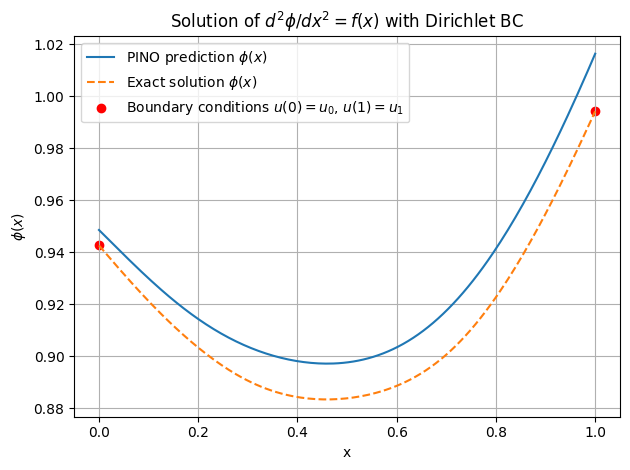

In [3]:
# --- 推論 2 : 初見の f(x), u0, u1 ---
print("推論 2 : 初見の f(x), u0, u1")
f_test = f_unknown
bc_test = bc_unknown


f_sample_test = f_test(x_sample).reshape(-1)
f_input_test = jnp.concatenate([f_sample_test, bc_test])[None, :]
x_plot = jnp.linspace(0, 1, 200).reshape(-1, 1)
u_pred = solver.predict(f_input_test, x_plot)[0]

# --- プロット ---
u_exact_test = solve_poisson_bvp(f_test, bc_test, x_plot)
plt.plot(x_plot[:, 0], u_pred, label="PINO prediction $\phi(x)$")
plt.plot(x_plot[:, 0], u_exact_test, '--', label="Exact solution $\phi(x)$")
plt.scatter(x_obs[:,0], bc_test, c="r", label="Boundary conditions $u(0)=u_0$, $u(1)=u_1$")
plt.xlabel("x")
plt.ylabel("$\phi(x)$")
plt.title("Solution of $d^2\phi/dx^2 = f(x)$ with Dirichlet BC")
plt.grid(); plt.legend(); plt.tight_layout(); plt.show()

# # --- ２階微分チェック ---
# u_pred, dudx_pred, d2udx2_pred = solver.predict_with_derivatives(f_input_test, x_plot)[0].T
# plt.plot(x_sample[:,0], f_sample_test, label="Given f(x)")
# plt.plot(x_plot[:,0], d2udx2_pred, '--', label="Pino prediction d^2u/dx^2")
# plt.xlabel("x")
# plt.title("Check $d^2\phi/dx^2 = f(x)$")
# plt.grid(); plt.legend(); plt.tight_layout(); plt.show()